In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import pyspedas
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

Load IGRF coefficients ...


In [2]:
#REPPU otuputs
#path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Data/pbig5min.dat'
path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/wbig5min.dat'

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [3]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])
mhd_data

,start,end,total_days
0,2021/05/10,2021/05/14,5
1,2021/05/31,2021/06/03,4
2,2021/07/26,2021/07/29,4
3,2021/09/09,2021/09/12,4
4,2021/10/11,2021/10/14,4
5,2021/11/01,2021/11/06,6
6,2021/11/25,2021/11/29,5
7,2022/01/30,2022/02/03,5
8,2022/03/11,2022/03/15,5
9,2022/03/28,2022/04/01,5


In [5]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'conductivity': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['conductivity'].attrs['units'] = 's/M'
#ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 440MB
Dimensions:       (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt            (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat           (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon           (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    conductivity  (dt, lat, lon) float32 440MB 1.517 1.517 1.517 ... 5.173 5.166

In [6]:
#open the omni data and merge it with the REPPU data
omni_mhd_path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/'

omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_1min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset> Size: 409MB
Dimensions:         (dt: 42158, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 337kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    conductivity    (dt, lat, lon) float32 405MB 1.517 1.517 ... 5.173 5.166
    BY_GSE          (dt) float64 337kB 4.72 4.35 4.61 4.65 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 337kB 6.24 6.55 6.56 6.89 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 337kB 344.0 344.8 345.5 ... 454.7 465.0 478.1
    proton_density  (dt) float64 337kB 12.11 11.44 12.65 ... 8.03 7.08 6.84
    T               (dt) float64 337kB 2.457e+04 1.984e+04 ... 1.949e+05
    Pressure        (dt) float64 337kB 2.87 2.72 3.02 3.0 ... 3.33 3.06 3.13
    E               (dt) float64 337kB -2.63 -2.68 -2.73 ... -0.07 1.33 1.91
    Mach_num        (dt) float64 337kB 7.3 7.0 7.3 7.1 6.8 ... 6.0 6.6 5.9 6.5
    BSN_x           (dt) float64 337kB 12.82 12.85 12.72 ... 12.43 12.03 11.72
    doy             (dt) float64 337kB 130.0 130.0 130.0 ... 212.0 212.0 212.0
    tilt_angle      (dt) float64 337kB 0.253 0.2497 0.2465 ... 0.2744 0.271

In [7]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [9]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

#nan_count(ds_test, 'doy')

(5582, 0.0)

In [11]:
#training
X_train = ds_train.drop_vars('conductivity').to_array().values.T
y_train = ds_train['conductivity'].values
y_train = y_train.reshape(-1, 30*80) #flatten lat & lon

#testing
X_test = ds_test.drop_vars('conductivity').to_array().values.T
y_test = ds_test['conductivity'].values
y_test = y_test.reshape(-1, 30*80) #flatten lat & lon

In [12]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 250 #number of reservoir neurons

model = ESN(N_u = input_dim, N_y = output_dim, N_x=reservoir_size, density=0.1, input_scale=0.1, rho=0.99)
optimizer = Tikhonov(N_u = input_dim, N_x = reservoir_size, N_y = output_dim, beta=1e-3)
model.train(X_train, y_train, optimizer)

array([[  17081.68465183,   11935.23969083,  -40296.32552936, ...,
         -91018.93600377,   69156.01946551,    1930.89232848],
       [  13813.04158427,    9576.47099223,  -32580.31951993, ...,
         -73508.4436592 ,   55801.44436945,    1582.94213528],
       [  17522.33718465,   12251.68806333,  -41337.19529584, ...,
         -93378.30429133,   70954.94740347,    1980.49007514],
       ...,
       [  39079.62082521,   27722.24867973,  -92185.56066083, ...,
        -208655.42244318,  158850.74133283,    4145.88896385],
       [  32006.09951227,   22618.46882393,  -75484.21897417, ...,
        -170756.74910347,  129949.83788657,    3392.24435234],
       [  32772.53838045,   23173.12358709,  -77293.7006174 , ...,
        -174865.47838991,  133083.47017273,    3473.69408075]])

In [13]:
y_pred = model.predict(X_test) #predict the test data
y_pred = y_pred.reshape(-1, 30, 80) #reshape the prediction to lat, lon
y_pred.shape

(5582, 30, 80)

In [14]:
# Create xarray Dataset
ds_pred = xr.Dataset({'conductivity': (['dt', 'lat', 'lon'], y_pred)},
                coords={'dt': ds_test['dt'], 'lat': ds_test['lat'], 'lon': ds_test['lon']})

# Add conductivity and units
ds_pred['conductivity'].attrs['units'] = 'S/m'
ds_pred

#add other variables to the prediction dataset
ds_pred = ds_pred.merge(ds_test.drop_vars('conductivity'))
ds_pred

<xarray.Dataset> Size: 108MB
Dimensions:         (dt: 5582, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 45kB 2022-07-11T15:05:00 ... 2022-07-...
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    conductivity    (dt, lat, lon) float64 107MB 1.517 1.517 ... 5.066 5.067
    BY_GSE          (dt) float64 45kB 7.96 8.2 8.13 8.94 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 45kB -3.35 -2.99 -2.57 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 45kB 340.7 341.9 337.1 ... 454.7 465.0 478.1
    proton_density  (dt) float64 45kB 9.32 9.77 10.02 9.5 ... 8.03 7.08 6.84
    T               (dt) float64 45kB 5.825e+04 5.987e+04 ... 1.949e+05
    Pressure        (dt) float64 45kB 2.16 2.29 2.28 2.15 ... 3.33 3.06 3.13
    E               (dt) float64 45kB 1.71 1.62 1.44 1.41 ... -0.07 1.33 1.91
    Mach_num        (dt) float64 45kB 5.0 5.0 5.0 4.8 4.9 ... 6.0 6.6 5.9 6.5
    BSN_x           (dt) float64 45kB 12.98 12.93 13.07 ... 12.43 12.03 11.72
    doy             (dt) float64 45kB 192.0 192.0 192.0 ... 212.0 212.0 212.0
    tilt_angle      (dt) float64 45kB 0.5268 0.5285 0.5301 ... 0.2744 0.271

01-Apr-24 15:51:14: <>:19: SyntaxWarning: invalid escape sequence '\M'

01-Apr-24 15:51:14: <>:19: SyntaxWarning: invalid escape sequence '\M'

01-Apr-24 15:51:14: /var/folders/n2/t9qn3_vj3nd6jb505jq_l8dw0000gn/T/ipykernel_30186/1487959239.py:19: SyntaxWarning: invalid escape sequence '\M'
  plt.annotate(f'RMSE = {rmse:.2f} s\M', xy=(0.77, 0.1), xycoords='axes fraction')



Text(0, 0.5, 'Conductivity [S/m]')

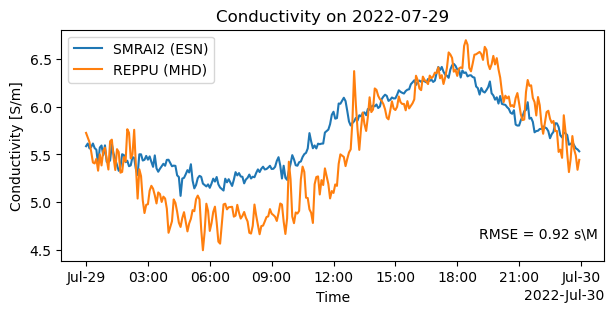

In [99]:
#plot potential on 2022-07-11, integrtaed over lat and lon

#2022-07-14 is worst
#2022-07-15 is worst

#2022-07-22 is good
#2022-07-23 is good
#2022-07-28 is good
#2022-07-30 is good

#2022-07-24 is best
#2022-07-29 is best
date = '2022-07-29'
fig, ax = plt.subplots(figsize=(7, 3))
ds_pred['conductivity'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (ESN)')
ds_test['conductivity'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (MHD)')

rmse = np.sqrt(np.mean((ds_pred['conductivity'].sel(dt=date).values - ds_test['conductivity'].sel(dt=date).values)**2))
plt.annotate(f'RMSE = {rmse:.2f} s\M', xy=(0.77, 0.1), xycoords='axes fraction')

plt.legend()
plt.title(f'Conductivity on {date}')
plt.xlabel('Time')
phi = r'$\phi$'
plt.ylabel(f'Conductivity [S/m]')


In [72]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
rmse_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['conductivity'].sel(dt=date).values - ds_test['conductivity'].sel(dt=date).values)**2))
    rmse_list.append(rmse)

rmse_df = pd.DataFrame(rmse_list, columns=['RMSE'])
rmse_df['dt'] = ds_test['dt']

rmse_df['date'] = rmse_df['dt'].dt.date
rmse_df['hr'] = rmse_df['dt'].dt.hour
rmse_df

,RMSE,dt,date,hr
0,1.141561,2022-07-11 15:05:00,2022-07-11,15
1,1.199593,2022-07-11 15:10:00,2022-07-11,15
2,1.413136,2022-07-11 15:15:00,2022-07-11,15
3,1.687081,2022-07-11 15:20:00,2022-07-11,15
4,1.694694,2022-07-11 15:25:00,2022-07-11,15
...,...,...,...,...
5577,1.367585,2022-07-31 23:35:00,2022-07-31,23
5578,1.739722,2022-07-31 23:40:00,2022-07-31,23
5579,1.678932,2022-07-31 23:45:00,2022-07-31,23
5580,1.363559,2022-07-31 23:50:00,2022-07-31,23


In [92]:
rmse_df.groupby('date').mean().sort_values(by='RMSE', ascending=True)

,RMSE,dt,hr
date,,,
2022-07-29,0.899566,2022-07-29 11:59:08.936169984,11.524823
2022-07-24,1.050478,2022-07-24 11:57:06.923076864,11.493007
2022-07-25,1.059502,2022-07-25 12:01:45.263157760,11.571930
2022-07-20,1.105903,2022-07-20 11:50:51.063829760,11.390071
2022-07-28,1.140306,2022-07-28 11:58:26.451612928,11.516129
2022-07-30,1.170307,2022-07-30 11:58:31.267605760,11.517606
2022-07-27,1.299710,2022-07-27 11:57:47.832167680,11.503497
2022-07-13,1.324836,2022-07-13 10:48:32.790697728,10.348837
2022-07-17,1.447694,2022-07-17 11:56:00.854092288,11.476868


Text(0, 0.5, 'RMSE [S/m]')

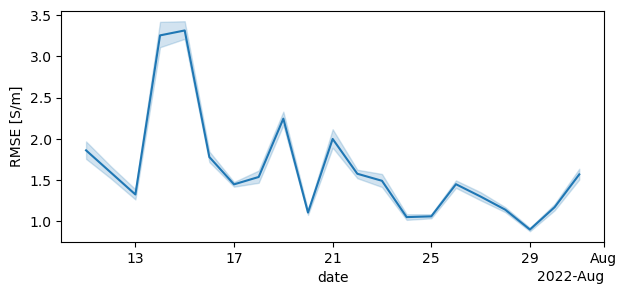

In [83]:
#plot the RMSE
fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(data=rmse_df, x='date', y='RMSE', ax=ax)
plt.ylabel('RMSE [S/m]')
#plt.xticks(np.arange(0, 25, 3))
#plt.xlabel('UTC')

In [23]:
#print unique dates from ds_pred dt
dates = ds_pred['dt'].dt.strftime('%Y-%m-%d').values
unique_dates = np.unique(dates)
unique_dates

array(['2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
       '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
       '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
       '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26',
       '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30',
       '2022-07-31'], dtype=object)

In [24]:
date = '2022-07-31'

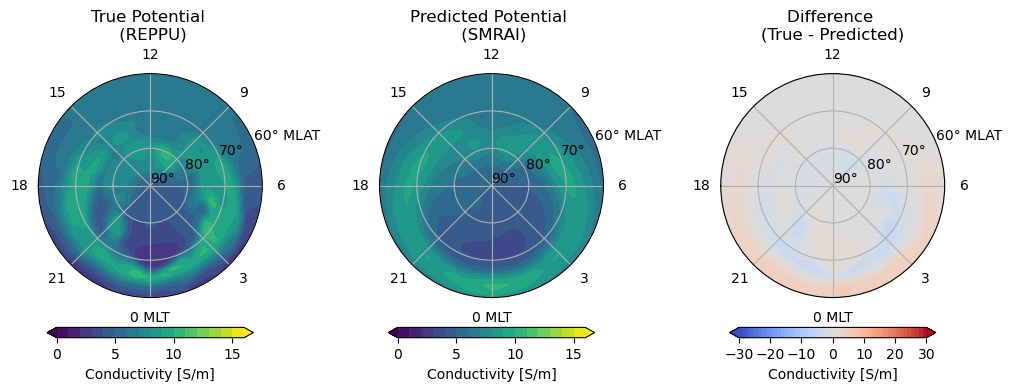

In [45]:
# Define the date
date = "2022-07-31"

# Extract true and predicted values
cond_true = ds_test['conductivity'].sel(dt=date).values[0]
cond_pred = ds_pred['conductivity'].sel(dt=date).values[0]

# Calculate the difference
diff = cond_true - cond_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, cond_true, levels=np.arange(0, 17, 1), cmap='viridis', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 17, 5), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, cond_pred, levels=np.arange(0, 17, 1), cmap='viridis', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 17, 5), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='coolwarm', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()


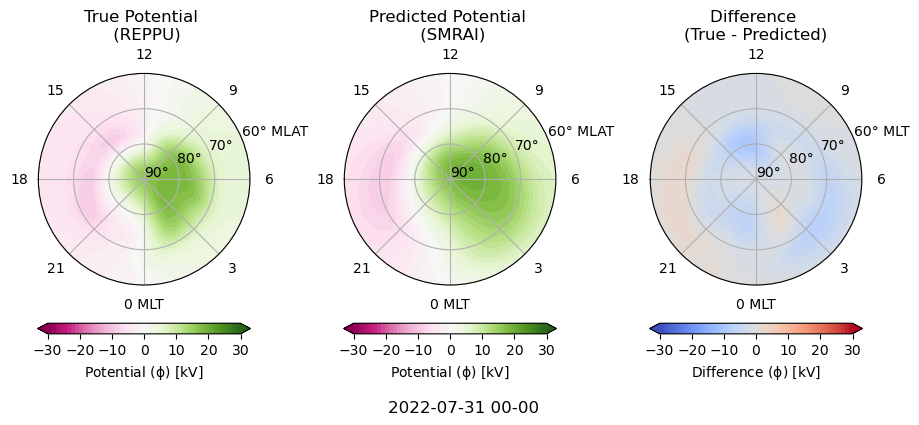

In [16]:

# Select the date
date = "2022-07-31"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .28
pad = 0.13
phi = r"$\mathrm{\phi}$"

# Loop through each time step
for i, time in enumerate(times):
    # Extract true and predicted values for the current time
    pot_true = ds_test['potential'].sel(dt=date).values[i]
    pot_pred = ds_pred['potential'].sel(dt=date).values[i]

    # Calculate the difference
    diff = pot_true - pot_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[0].set_title(f'True Potential \n (REPPU)')
    plt.colorbar(c_true, ax=axs[0], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[1].set_title('Predicted Potential \n (SMRAI)')
    plt.colorbar(c_pred, ax=axs[1], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot difference
    c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='coolwarm', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[2].set_title(f'Difference \n(True - Predicted)')
    plt.colorbar(c_diff, ax=axs[2], label=f'Difference ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    plt.subplots_adjust(wspace=-0.8)  # Adjust horizontal space between subplots

    plt.tight_layout()

    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')

    plt.annotate(f'{str_time}', xy=(-1.24, -0.6), xycoords='axes fraction', fontsize=12)

    # Save the figure with the timestamp in the title
    #export_path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/Research/JSPS/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/'
    #plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/potential_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    #plt.close(fig)

    break